In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from databallpy.visualize import plot_soccer_pitch, plot_tracking_data
from databallpy import get_saved_game
from IPython.display import display

player_id = "home_25"
game_id = "J03WQQ"
parameters = "5.0_1.0_2.0_20"
provider = "IDSSE"
top_n = 5
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)

full_df = pd.read_csv("output/full_das.csv")
df_player = full_df[
    (full_df["player"] == player_id) &
    (full_df["match_id"] == game_id) &
    (full_df["parameters"] == parameters)
]

frame_scores = (
    df_player.groupby("frame")["DAS_potential_percentage"]
    .max()
    .sort_values(ascending=False)
    .head(5)
)

top_frames = frame_scores.index.to_list()
# Nur für Entwicklung
top_frame = top_frames[0]

df_top_frames_all_methods = df_player[df_player["frame"].isin(top_frames)]

# df_top_frames_all_methods

In [ ]:
def plot_frame(df, frame_id, player_id, game_id, provider):
    df_frame = df[(df["frame"] == frame_id)].reset_index()
    row = df_frame.iloc[0]
    move_x = row["move_x"]
    move_y = row["move_y"]
    game = load_game_data(provider, game_id)
    idx = game.tracking_data[game.tracking_data["frame"]==frame_id].index[0]
    
    add_optimized_position_to_game(game, player_id, move_x, move_y, idx, frame_id)
    display(game.tracking_data.loc[idx])
    prep_game_data(game)
    display(game.tracking_data.loc[idx])
    
    fig, ax = plt.subplots(figsize=(12,8))
    fig, ax = plot_soccer_pitch(pitch_color="white", fig=fig, ax=ax)
    fig, ax = plot_tracking_data(
        game,
        idx,
        fig=fig,
        ax=ax,
        title=f"Optimierte Positionen - Frame {frame_id} - Spieler {player_id}"
    )
    highlight_player(ax, game, idx, player_id)
    highlight_player(ax, game, idx, "home_99", color="blue")

    plt.show()
    return game
    
def load_game_data(provider, game_id):
    if provider == "metrica":
        path = f"../datasets/"
    else:
        path = f"../datasets/{provider}"
    game = get_saved_game(name=game_id, path=path)
    return game

def prep_game_data(game, max_velocity=25):
    col_ids = game.get_column_ids() + ["ball"]
    game.tracking_data.add_velocity(column_ids=col_ids, max_velocity=max_velocity)
    game.synchronise_tracking_and_event_data()
    game.tracking_data.add_individual_player_possession()

def add_optimized_position_to_game(game, player_id, move_x, move_y, idx, frame):
    opt_player_id = f"{player_id.rsplit('_')[0]}_99"
    x_col = f"{opt_player_id}_x"
    y_col = f"{opt_player_id}_y"
    
    orig_x = game.tracking_data.at[idx, f"{player_id}_x"]
    orig_y = game.tracking_data.at[idx, f"{player_id}_y"]
    x = orig_x + move_x
    y = orig_y + move_y
    
    if x_col not in game.tracking_data.columns:
        game.tracking_data[x_col] = np.nan
        game.tracking_data[y_col] = np.nan
    
    game.tracking_data.at[idx, x_col] = x
    game.tracking_data.at[idx, y_col] = y
    
    if "OPT_99" not in game.home_players["id"].to_list():
        player = {
            'id': "OPT_99",
            'full_name': "Optimised Player",
            'shirt_num': 99, 
            'position': "unspecified",
            'start_frame': -999,
            'end_frame': -999,
            'starter': False
        }
        game.home_players = pd.concat([game.home_players, pd.DataFrame([player])])
        
def highlight_player(ax, game, idx, player_col_id, color="black", radius=1.0):
    x = game.tracking_data.loc[idx, f"{player_col_id}_x"]
    y = game.tracking_data.loc[idx, f"{player_col_id}_y"]
    
    if pd.isna(x) or pd.isna(y):
        return
    
    circle = plt.Circle((x,y), radius=radius, fill=False, lw=2.5, zorder=3.5, color=color)
    ax.add_patch(circle)

,frame,ball_x,ball_y,ball_z,ball_status,team_possession,datetime,home_28_x,home_28_y,home_25_x,home_25_y,home_29_x,home_29_y,home_9_x,home_9_y,home_19_x,home_19_y,home_33_x,home_33_y,home_23_x,home_23_y,home_15_x,home_15_y,home_7_x,home_7_y,home_5_x,home_5_y,home_8_x,home_8_y,away_23_x,away_23_y,away_7_x,away_7_y,away_2_x,away_2_y,away_10_x,away_10_y,away_13_x,away_13_y,away_22_x,away_22_y,away_14_x,away_14_y,away_8_x,away_8_y,away_20_x,away_20_y,away_25_x,away_25_y,away_5_x,away_5_y,home_13_x,home_13_y,home_3_x,home_3_y,home_11_x,home_11_y,home_14_x,home_14_y,away_19_x,away_19_y,away_11_x,away_11_y,away_27_x,away_27_y,away_34_x,away_34_y,away_24_x,period_id,away_24_y,gametime_td,home_99_x,home_99_y
0,10000,2.79,0.35,0.23,alive,away,2022-11-05 13:01:28.120000+01:00,0.29,9.13,-21.93,-11.42,-11.58,7.44,0.33,-10.02,-7.95,19.00,-39.53,-0.6,-4.83,7.68,-21.90,8.32,-5.55,-19.89,-23.19,-4.19,-10.87,-7.74,0.08,-27.17,4.92,8.31,6.54,21.19,1.14,-15.88,-0.79,-9.00,36.84,-0.16,0.52,-2.53,-0.41,0.20,7.36,-8.89,21.40,5.52,18.94,-9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,00:00,NaN,NaN
1,10001,3.61,0.49,0.22,alive,away,2022-11-05 13:01:28.160000+01:00,0.37,9.08,-21.92,-11.48,-11.57,7.44,0.44,-9.99,-7.93,18.98,-39.54,-0.6,-4.85,7.66,-21.90,8.28,-5.56,-19.89,-23.18,-4.22,-10.86,-7.74,0.08,-27.14,4.93,8.27,6.55,21.19,1.12,-15.90,-0.89,-9.04,36.85,-0.16,0.51,-2.54,-0.40,0.20,7.37,-8.89,21.42,5.48,18.97,-9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,00:00,NaN,NaN
2,10002,4.42,0.62,0.19,alive,home,2022-11-05 13:01:28.200000+01:00,0.44,9.04,-21.91,-11.53,-11.56,7.44,0.56,-9.95,-7.90,18.96,-39.54,-0.6,-4.86,7.66,-21.91,8.25,-5.56,-19.89,-23.17,-4.25,-10.84,-7.75,0.07,-27.10,4.95,8.23,6.55,21.20,1.10,-15.93,-1.00,-9.08,36.87,-0.15,0.50,-2.56,-0.39,0.19,7.37,-8.89,21.43,5.44,18.99,-9.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,00:00,NaN,NaN
3,10003,5.22,0.76,0.14,alive,away,2022-11-05 13:01:28.240000+01:00,0.53,8.98,-21.90,-11.58,-11.54,7.44,0.67,-9.91,-7.88,18.95,-39.55,-0.6,-4.88,7.65,-21.91,8.21,-5.56,-19.89,-23.15,-4.28,-10.83,-7.76,0.07,-27.07,4.96,8.19,6.55,21.20,1.08,-15.95,-1.11,-9.13,36.89,-0.13,0.48,-2.57,-0.39,0.18,7.37,-8.89,21.46,5.40,19.03,-9.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,00:00,NaN,NaN
4,10004,5.95,0.89,0.17,alive,away,2022-11-05 13:01:28.280000+01:00,0.62,8.93,-21.89,-11.63,-11.53,7.44,0.79,-9.86,-7.86,18.93,-39.55,-0.6,-4.90,7.64,-21.92,8.18,-5.56,-19.89,-23.14,-4.30,-10.83,-7.78,0.07,-27.04,4.98,8.15,6.55,21.20,1.04,-15.98,-1.24,-9.18,36.90,-0.12,0.47,-2.59,-0.40,0.18,7.38,-8.89,21.47,5.36,19.06,-9.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,00:00,NaN,NaN


,frame,ball_x,ball_y,ball_z,ball_status,team_possession,datetime,home_28_x,home_28_y,home_25_x,home_25_y,home_29_x,home_29_y,home_9_x,home_9_y,home_19_x,home_19_y,home_33_x,home_33_y,home_23_x,home_23_y,home_15_x,home_15_y,home_7_x,home_7_y,home_5_x,home_5_y,home_8_x,home_8_y,away_23_x,away_23_y,away_7_x,away_7_y,away_2_x,away_2_y,away_10_x,away_10_y,away_13_x,away_13_y,away_22_x,away_22_y,away_14_x,away_14_y,away_8_x,away_8_y,away_20_x,away_20_y,away_25_x,away_25_y,away_5_x,away_5_y,home_13_x,home_13_y,home_3_x,home_3_y,home_11_x,home_11_y,home_14_x,home_14_y,away_19_x,away_19_y,away_11_x,away_11_y,away_27_x,away_27_y,away_34_x,away_34_y,away_24_x,period_id,away_24_y,gametime_td,home_99_x,home_99_y,home_13_vx,home_13_vy,home_13_velocity,home_28_vx,home_28_vy,home_28_velocity,home_25_vx,home_25_vy,home_25_velocity,home_3_vx,home_3_vy,home_3_velocity,home_11_vx,home_11_vy,home_11_velocity,home_29_vx,home_29_vy,home_29_velocity,home_9_vx,home_9_vy,home_9_velocity,home_19_vx,home_19_vy,home_19_velocity,home_33_vx,home_33_vy,home_33_velocity,home_23_vx,home_23_vy,home_23_velocity,home_15_vx,home_15_vy,home_15_velocity,home_7_vx,home_7_vy,home_7_velocity,home_5_vx,home_5_vy,home_5_velocity,home_8_vx,home_8_vy,home_8_velocity,home_14_vx,home_14_vy,home_14_velocity,home_99_vx,home_99_vy,home_99_velocity,away_19_vx,away_19_vy,away_19_velocity,away_23_vx,away_23_vy,away_23_velocity,away_7_vx,away_7_vy,away_7_velocity,away_2_vx,away_2_vy,away_2_velocity,away_10_vx,away_10_vy,away_10_velocity,away_11_vx,away_11_vy,away_11_velocity,away_13_vx,away_13_vy,away_13_velocity,away_27_vx,away_27_vy,away_27_velocity,away_22_vx,away_22_vy,away_22_velocity,away_14_vx,away_14_vy,away_14_velocity,away_8_vx,away_8_vy,away_8_velocity,away_20_vx,away_20_vy,away_20_velocity,away_34_vx,away_34_vy,away_34_velocity,away_25_vx,away_25_vy,away_25_velocity,away_24_vx,away_24_vy,away_24_velocity,away_5_vx,away_5_vy,away_5_velocity,ball_vx,ball_vy,ball_velocity,ball_ax,ball_ay,ball_acceleration,databallpy_event,event_id,sync_certainty,player_possession
0,10000,2.79,0.35,0.23,alive,away,2022-11-05 13:01:28.120000+01:00,0.29,9.13,-21.93,-11.42,-11.58,7.44,0.33,-10.02,-7.95,19.00,-39.53,-0.6,-4.83,7.68,-21.90,8.32,-5.55,-19.89,-23.19,-4.19,-10.87,-7.74,0.08,-27.17,4.92,8.31,6.54,21.19,1.14,-15.88,-0.79,-9.00,36.84,-0.16,0.52,-2.53,-0.41,0.20,7.36,-8.89,21.40,5.52,18.94,-9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,00:00,NaN,NaN,NaN,NaN,NaN,2.000,-1.250,2.358495,0.25,-1.500,1.520691,NaN,NaN,NaN,NaN,NaN,NaN,0.250,0.0,0.250,2.750,0.750,2.850439,0.500,-0.500,0.707107,-0.250,0.0,0.250,-0.500,-0.500,0.707107,0.000,-1.000,1.000000,-0.250,0.000,0.250,0.250,-0.750,0.790569,0.250,0.000,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.750,0.750000,0.250,-1.0,1.030776,0.250,0.000,0.250000,-0.500,-0.500,0.707107,NaN,NaN,NaN,-2.500,-1.000,2.692582,NaN,NaN,NaN,0.250,0.000,0.250000,-0.250,-0.250,0.353553,0.250,0.000,0.250000,0.250,0.0,0.250,NaN,NaN,NaN,0.500,-1.0,1.118034,NaN,NaN,NaN,0.750,-0.750,1.060660,20.500,3.500,20.796634,-0.409226,-2.306548,2.342569,None,-999,NaN,None
1,10001,3.61,0.49,0.22,alive,away,2022-11-05 13:01:28.160000+01:00,0.37,9.08,-21.92,-11.48,-11.57,7.44,0.44,-9.99,-7.93,18.98,-39.54,-0.6,-4.85,7.66,-21.90,8.28,-5.56,-19.89,-23.18,-4.22,-10.86,-7.74,0.08,-27.14,4.93,8.27,6.55,21.19,1.12,-15.90,-0.89,-9.04,36.85,-0.16,0.51,-2.54,-0.40,0.20,7.37,-8.89,21.42,5.48,18.97,-9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,00:00,NaN,NaN,NaN,NaN,NaN,1.875,-1.125,2.186607,0.25,-1.375,1.397542,NaN,NaN,NaN,NaN,NaN,NaN,0.250,0.0,0.250,2.875,0.875,3.005204,0.625,-0.500,0.800391,-0.125,0.0,0.125,-0.375,-0.250,0.450694,-0.125,-0.875,0.883883,-0.125,0.000,0.125,0.250,-0.750,0.790569,0.375,-0.125,0.395285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.125,0.875,0.883883,0.375,-1.0,1.068000,0.125,0.125,0.176777,-0.500,-0.625,0.800391,NaN,NaN,NaN,-2.625,-1.000,2.809026,NaN,NaN,NaN,0.375,0.125,0.395285,-0.250,-0.375,0.45

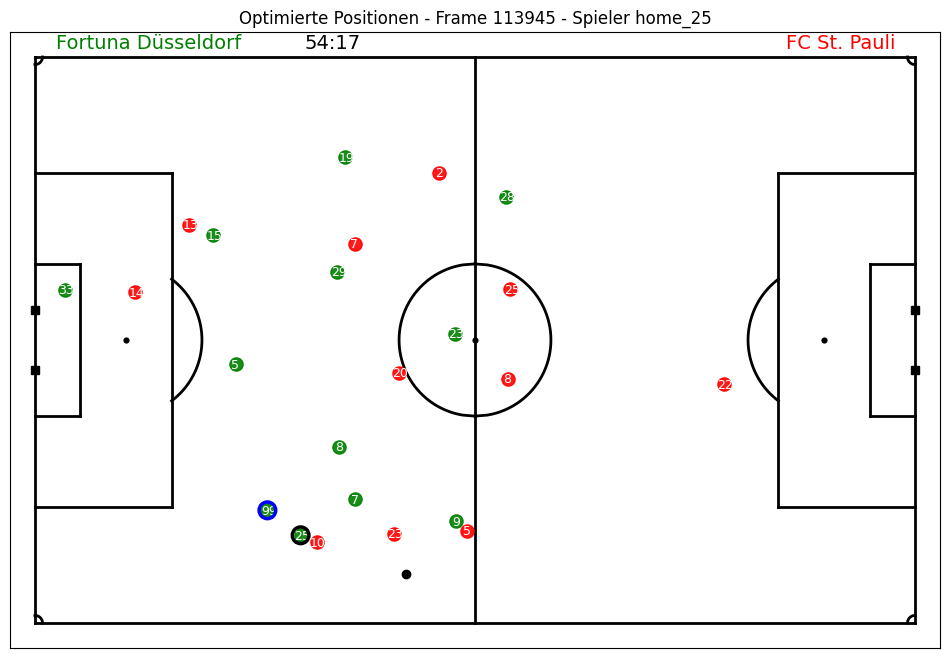

In [16]:
game = plot_frame(df_top_frames_all_methods, top_frame, player_id, game_id, provider)